In [4]:
import os
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr,kendalltau
from sklearn.metrics import accuracy_score,f1_score,recall_score,confusion_matrix
from sklearn.calibration import calibration_curve

acts = ['brushing','combing','deodrant','drinking','facewash','feeding','glasses','shelf','RTT']
name_to_ID = {'reach':0, 'transport':1, 'reposition':2, 'stabilize':3, 'rest':4, 'retract':2, 'idle':4 }


In [3]:
def process_pred(feature_dir,test_list):
    np_list = os.listdir(feature_dir)
    Merge_dict = {}
    for file in np_list: # s0e31.npy
        tempt = np.load(os.path.join(feature_dir,file), allow_pickle=True)
        tempt = tempt[()]   #dict
        for key in tempt.keys(): #1,2,3,4...
            Merge_dict[key] = tempt[key]

    np.save(feature_dir.replace('/test','/merge_test')+'.npy',Merge_dict)

    unique_video_dict = {}
    unique_video_label_dict = {}
    with open(test_list, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        for idx, row in enumerate(spamreader):
            path = row[0]   # /gpfs/scratch/kl3141/processed_video/processed_video_kn_square_512_2s_withflip_0329/S00047/S00047_shelf_right_side2_1/s0e2_0.mp4
            video_name = path.split('/')[-2]   #  S00047_shelf_right_side2_1
            if not video_name in unique_video_dict.keys():
                unique_video_dict[video_name] = [idx,0]  # record the start idx
                unique_video_label_dict[video_name] = [int(path.split('/')[-1].split('.')[0].split('_')[1])]  # record the label
            else:
                unique_video_dict[video_name][1] = unique_video_dict[video_name][1]+1   # count the number of files
                unique_video_label_dict[video_name].append(int(path.split('/')[-1].split('.')[0].split('_')[1]))

    feature_test_path = feature_dir.replace('/test','/merge_test')+'.npy'
    feature_test = np.load(feature_test_path,allow_pickle=True)[()]

    save_dir = feature_dir.replace('/test','/processed_videos/test')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for video_name in unique_video_dict.keys():
        incomplete_sign =False
        [start, duration] = unique_video_dict[video_name]
        merged_file_list = []
        for time in range(start, duration+start+1):
            if time in feature_test.keys():
                merged_file_list.append(feature_test[time])
            else:
                # the video is incomplete, give it up
                incomplete_sign = True
                print(video_name)
                break
        if not incomplete_sign:
            merged_file_video = np.vstack(merged_file_list)
            np.save(os.path.join(save_dir, video_name+'.npy'), merged_file_video)
            np.save(os.path.join(save_dir, video_name+'_label.npy'), np.array(unique_video_label_dict[video_name]))




In [5]:

def balanced_acc_5_cls(pred,true): 
    unique, counts = np.unique(true, return_counts=True)
    acc = 0
    for u in unique:
        pred_cls = pred[true==u]
        true_cls = true[true==u]
        acc+=accuracy_score(pred_cls,true_cls)
    #print(acc)
    return acc/unique.shape[0]

def evaluate_model(processed_video_dir,):
    confidence_ = {}
    confidence_['sub'] = []
    confidence_['act'] = []
    confidence_['side'] = []
    confidence_['rep'] = []
    confidence_['prob'] = []
    confidence_['label'] = []
    for f in os.listdir(processed_video_dir):
        if 'label' not in f:
            #'RTC00030_RTT_right_side3_2.npy'
            sub = f.split('000')[1].split('_')[0]
            for a in acts:
                    if a=='deodrant':
                        if 'deodrant' in f or 'deodorant' in f:
                            act = a
                    elif a=='facewash':
                        if 'face' in f:
                            act = a
                    else:
                        if a in f:
                            act = a
            side = f[0]
            rep = f.split('.n')[0][-3:]
            prob = np.load(processed_video_dir+'/'+f)#.max(axis=1)
            label = np.load(processed_video_dir+'/'+f.replace('.npy','_label.npy'))
            confidence_['sub'].append(sub)
            confidence_['act'].append(act)
            confidence_['side'].append(side)
            confidence_['rep'].append(rep)
            confidence_['prob'].append(prob)
            confidence_['label'].append(label)
    df = pd.DataFrame(confidence_)
    pred = np.concatenate(df.prob.values)
    label = np.concatenate(df.label).astype('int')
    print('err: {:4f}'.format(100-100*accuracy_score(y_true=label,y_pred=pred.argmax(axis=1))))
    print('balanced_acc: {:4f}'.format(balanced_acc_5_cls(pred=pred.argmax(axis=1), true=label)))
    print('f1_score: {:4f}'.format(f1_score(y_true=label,y_pred=pred.argmax(axis=1),average = 'macro')))
    print('recall_score: {:4f}'.format(recall_score(y_true=label,y_pred=pred.argmax(axis=1),average = 'macro')))
    
    
    fig, axes = plt.subplots(1,5,figsize=(15,3))
    for i in range(5):
        prob_true, prob_pred = calibration_curve(y_true=(label==i).astype('int'),
                                                 y_prob=pred[:,i],
                                                 n_bins=5)
        axes[i].plot(prob_pred,prob_true,marker='o')
        axes[i].plot([0,1],[0,1], ls='--', c='grey')
        axes[i].set_title(f'class {i}')
    plt.show()
    return df



In [14]:
def performance_bootstrap_ci(df, rep=100, n=9999, level = 0.95):
    gt = np.concatenate(df.label.values).astype('int')
    probs = np.concatenate(df.prob.map(lambda x: x.argmax(axis=1)).values)
    motion_class_acc = []
    motion_class_precision = []
    overall_acc = []
    overall_precision = []
    for i in range(rep):
        id_sampled = np.random.choice(range(gt.shape[0]), n, replace = True)
        gt_sampled = gt[id_sampled]
        probs_sampled = probs[id_sampled]
        a = confusion_matrix(gt_sampled,probs_sampled)
        motion_class_acc.append((a[1][1]/a[1].sum()+a[2][2]/a[2].sum()+a[4][4]/a[4].sum())/3)
        motion_class_precision.append((a[1][1]/a[:,1].sum()+a[2][2]/a[:,2].sum()+a[4][4]/a[:,4].sum())/3)
        overall_acc.append(recall_score(gt_sampled,probs_sampled,average='macro'))
        overall_precision.append((a[0][0]/a[:,0].sum()+a[1][1]/a[:,1].sum()+a[2][2]/a[:,2].sum()+a[3][3]/a[:,3].sum()+a[4][4]/a[:,4].sum())/5)
            
    return {'motion class acc': (np.mean(motion_class_acc), np.percentile(motion_class_acc, [5,95],)),
            'motion class precision': (np.mean(motion_class_precision), np.percentile(motion_class_precision, [5,95],)),
            'overall acc': (np.mean(overall_acc), np.percentile(overall_acc, [5,95],)),
            'overall precision': (np.mean(overall_precision), np.percentile(overall_precision, [5,95],)),
           }

In [6]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [8]:
def generate_COBRA_from_prob(HC_dir,HAR_dir, act='brushing',plot=False):
    confidence_hc = {}
    confidence_hc['sub'] = []
    confidence_hc['act'] = []
    #confidence_hc['side'] = []
    confidence_hc['rep'] = []
    confidence_hc['prob'] = []
    confidence_hc['label'] = []
    for f in os.listdir(HC_dir):
        if 'label' not in f:
            #'RTC00030_RTT_right_side3_2.npy'
            sub = f.split('000')[1].split('_')[0]
            for a in acts:
                if a=='deodrant':
                    if 'deodrant' in f or 'deodorant' in f:
                        act=a
                elif a=='facewash':
                    if 'face' in f:
                        act=a
                else:
                    if a in f:
                        act=a                
            #side = f[0]
            rep = f.split('.n')[0][-3:]
            prob = np.load(HC_dir+'/'+f)
            label = np.load(HC_dir+'/'+f.replace('.npy','_label.npy'))
            confidence_hc['sub'].append(sub)
            confidence_hc['act'].append(act)
            #confidence_hc['side'].append(side)
            confidence_hc['rep'].append(rep)
            confidence_hc['prob'].append(prob)
            confidence_hc['label'].append(label)

    HC_df = pd.DataFrame(confidence_hc)
    #HC_df['medium_prob'] = HC_df.prob.map(lambda x: np.median(x.max(axis=1)))
    HC_df['motion_prob'] = HC_df[['prob','label']].apply(lambda x: np.mean(x[0].max(axis=1)[x[1]<3]),axis=1)
    HC_df['non_motion_prob'] = HC_df[['prob','label']].apply(lambda x: np.mean(x[0].max(axis=1)[x[1]>2]),axis=1)
    HC_df['all_prob'] = HC_df[['prob','label']].apply(lambda x: np.mean(x[0].max(axis=1)),axis=1)
    
    confidence_har = {}
    confidence_har['sub'] = []
    confidence_har['act'] = []
    #confidence_har['side'] = []
    confidence_har['rep'] = []
    confidence_har['prob'] = []
    confidence_har['label'] = []
    for f in os.listdir(HAR_dir):
        if 'label' not in f:
            #'S00025_RTT_right_side1_2.npy'
            sub = f.split('000')[1].split('_')[0]
            for a in acts:
                if a=='deodrant':
                    if 'deodrant' in f or 'deodorant' in f:
                        act=a
                elif a=='facewash':
                    if 'face' in f:
                        act=a
                else:
                    if a in f:
                        act=a                
            #side = f.split('RTT_')[1].split('_')[0][0].upper()
            rep = f.split('.n')[0][-3:]
            prob = np.load(HAR_dir+'/'+f)
            label = np.load(HAR_dir+'/'+f.replace('.npy','_label.npy'))
            confidence_har['sub'].append(sub)
            confidence_har['act'].append(act)
            #confidence_har['side'].append(side)
            confidence_har['rep'].append(rep)
            confidence_har['prob'].append(prob)
            confidence_har['label'].append(label)

    HAR_df = pd.DataFrame(confidence_har)
    #HAR_df['medium_prob'] = HAR_df.prob.map(lambda x: np.median(x.max(axis=1)))
    HAR_df['motion_prob'] = HAR_df[['prob','label']].apply(lambda x: np.mean(x[0].max(axis=1)[x[0].argmax(axis=1)<3]),axis=1)
    HAR_df['non_motion_prob'] = HAR_df[['prob','label']].apply(lambda x: np.mean(x[0].max(axis=1)[x[0].argmax(axis=1)>2]),axis=1)
    HAR_df['all_prob'] = HAR_df[['prob','label']].apply(lambda x: np.mean(x[0].max(axis=1)),axis=1)

    HAR_confidence_only = HAR_df.groupby('sub').mean()
    HAR_confidence_only.reset_index(drop=False, inplace=True)
    HAR_confidence_only['sub'] = HAR_confidence_only['sub'].astype('int')

    FM = pd.read_csv('FM_scores_2.csv')
    merged = FM.merge(HAR_confidence_only,left_on='Stroke Pt Number',right_on='sub')
    print('motion corr',spearmanr(merged['FM Score'],merged.motion_prob))
    print('motion corr',spearmanr(merged['FM Score'],merged.non_motion_prob))
    print('motion corr',spearmanr(merged['FM Score'],merged.all_prob))
    
    #print(kendalltau(merged['FM Score'],merged.medium_prob))
    #print(np.corrcoef(merged['FM Score'],merged.medium_prob)[0][1])
    if plot:
        fig, axes = plt.subplots(3,1,figsize=(1*4,3*4))

        axes[0].scatter(merged['FM Score'],merged.motion_prob,color='black')
        axes[0].set_ylim(0.3,1.)
        slope, intercept, r_value, p_value, std_err = stats.linregress(merged['FM Score'],merged.motion_prob)
        x = np.linspace(8, 70, num=5)
        line = [slope*ii for ii in x] + intercept
        axes[0].plot(x, line, '-', color='red',label = "spearman corr = {:.3f}".format(spearmanr(merged['FM Score'],merged.motion_prob)[0]))

        axes[1].scatter(merged['FM Score'],merged.non_motion_prob,color='black')
        axes[1].set_ylim(0.3,1.)
        slope, intercept, r_value, p_value, std_err = stats.linregress(merged['FM Score'],merged.non_motion_prob)
        x = np.linspace(8, 70, num=5)
        line = [slope*ii for ii in x] + intercept
        axes[1].plot(x, line, '-', color='red',label = "spearman corr = {:.3f}".format(spearmanr(merged['FM Score'],merged.non_motion_prob)[0]))

        axes[2].scatter(merged['FM Score'],merged.all_prob,color='black')
        axes[2].set_ylim(0.3,1.)
        slope, intercept, r_value, p_value, std_err = stats.linregress(merged['FM Score'],merged.all_prob)
        x = np.linspace(8, 70, num=5)
        line = [slope*ii for ii in x] + intercept
        axes[2].plot(x, line, '-', color='red',label = "spearman corr = {:.3f}".format(spearmanr(merged['FM Score'],merged.all_prob)[0]))

        for i in range(3):
            axes[i].legend()
        plt.show()
    return HC_df,HAR_df,merged

# combine all activities

early stop: val_top1_err,  healthy test set
err: 35.088662
balanced_acc: 0.584343
f1_score: 0.588710
recall_score: 0.584343


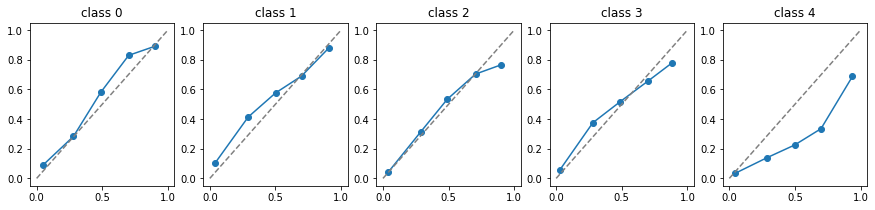

early stop: val_top1_err,  healthy test set
err: 35.505105
balanced_acc: 0.587426
f1_score: 0.591951
recall_score: 0.587426


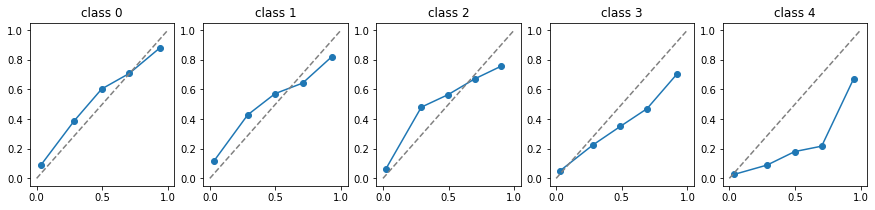

early stop: val_top1_err,  healthy test set
err: 30.145083
balanced_acc: 0.631630
f1_score: 0.643446
recall_score: 0.631630


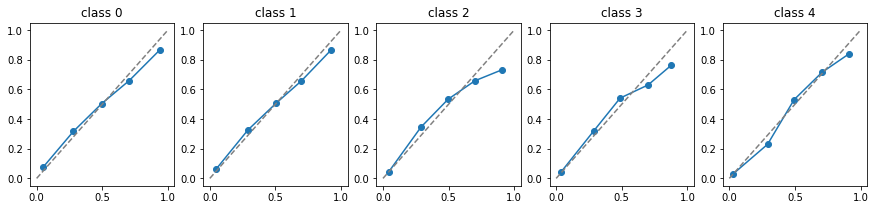

early stop: val_top1_err,  healthy test set
err: 29.997313
balanced_acc: 0.628107
f1_score: 0.644979
recall_score: 0.628107


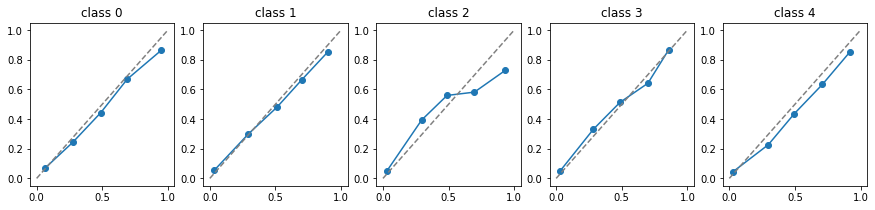

S00028_RTT_left_side5_2
early stop: val_top1_err,  stroke test set
err: 52.360214
balanced_acc: 0.450109
f1_score: 0.445684
recall_score: 0.450109


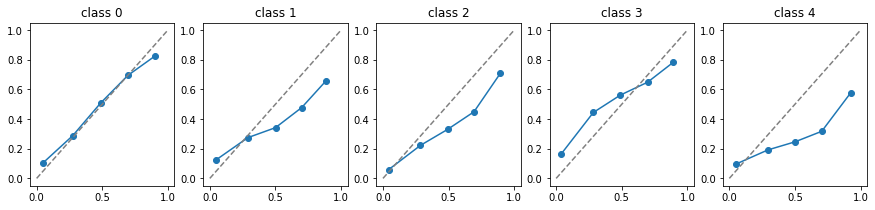

S00028_RTT_left_side5_2
early stop: val_top1_err,  stroke test set
err: 51.253253
balanced_acc: 0.448974
f1_score: 0.451110
recall_score: 0.448974


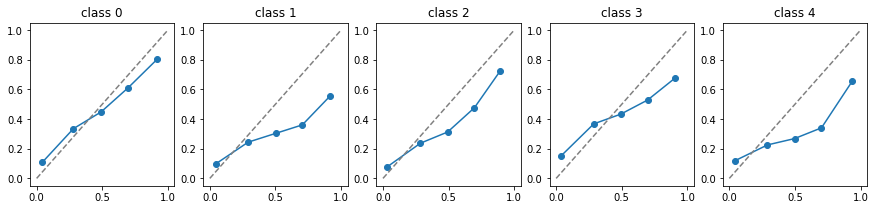

S00028_RTT_left_side5_2
early stop: val_top1_err,  stroke test set
err: 50.641121
balanced_acc: 0.476802
f1_score: 0.466504
recall_score: 0.476802


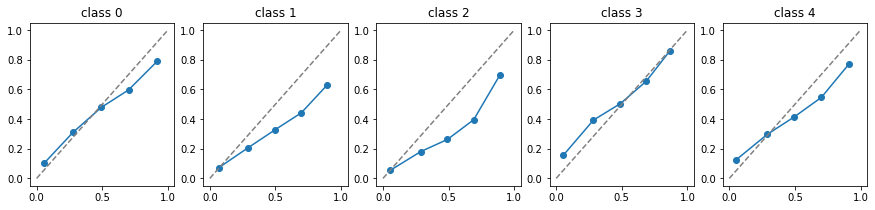

S00028_RTT_left_side5_2
early stop: val_top1_err,  stroke test set
err: 50.850109
balanced_acc: 0.463749
f1_score: 0.461987
recall_score: 0.463749


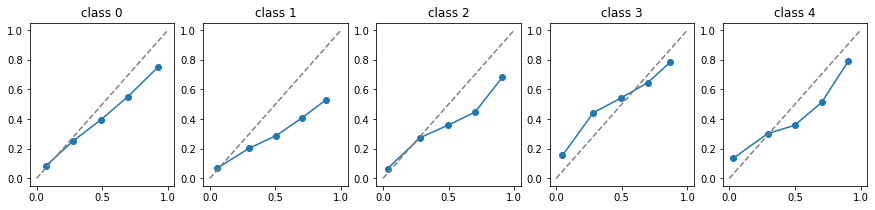

In [15]:
# healthy subjects
for i in range(1,5):
    feature_dir = f'extracted_logits/all_HC_split{i}_best_err/test'
    test_list = f'preprocessing/splits/split{i}/test/test.csv'
    process_pred(feature_dir,test_list)
    d = f'extracted_logits/0906_all_HC_split{i}_best_err/processed_videos/test'
    print('early stop: val_top1_err,  healthy test set')
    df = evaluate_model(d) 
    
# impaired subjects
for i in range(1,5):
    feature_dir = f'extracted_logits/all_HC_split{i}_best_err/test_stroke'
    test_list = f'preprocessing/splits/split{i}/test_stroke/test.csv'
    process_pred(feature_dir,test_list)
    d = f'extracted_logits/all_HC_split{i}_best_err/processed_videos/test_stroke'
    print('early stop: val_top1_err,  stroke test set')
    df = evaluate_model(d) 
    

In [12]:
HC_df = None
HAR_df = None
merged_df = None
for i in range(1,5):
    HC_dir=f'extracted_logits/all_HC_split{i}_best_err/processed_videos/test'
    HAR_dir=f'extracted_logits/all_HC_split{i}_best_err/processed_videos/test_stroke'
    
    HC_df_split,HAR_df_split,merged_df_split=generate_COBRA_from_prob(HC_dir,HAR_dir)
    
    if HC_df is None:
        HC_df = HC_df_split
    else:
        HC_df = pd.concat([HC_df,HC_df_split],ignore_index=True)
    
    if HAR_df is None:
        HAR_df = HAR_df_split
    else:
        HAR_df = pd.concat([HAR_df,HAR_df_split],ignore_index=True)

    if merged_df is None:
        merged_df = merged_df_split
    else:
        merged_df = pd.concat([merged_df,merged_df_split],ignore_index=True)



/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


motion corr SpearmanrResult(correlation=0.6379550729778901, pvalue=4.767165404746513e-07)
motion corr SpearmanrResult(correlation=-0.07626296180128962, pvalue=0.5947951087984984)
motion corr SpearmanrResult(correlation=0.12417639029639915, pvalue=0.3852962433170041)
motion corr SpearmanrResult(correlation=0.49471294223116863, pvalue=0.00022406529900252103)
motion corr SpearmanrResult(correlation=0.05470644765793223, pvalue=0.702993669249478)
motion corr SpearmanrResult(correlation=0.28720885020414416, pvalue=0.04100215225825268)
motion corr SpearmanrResult(correlation=0.6262257932234162, pvalue=8.87977057970786e-07)
motion corr SpearmanrResult(correlation=0.01693726111263796, pvalue=0.9060946109959611)
motion corr SpearmanrResult(correlation=0.39793506255815436, pvalue=0.0038298422164507414)
motion corr SpearmanrResult(correlation=0.6172137211340714, pvalue=1.4077015906753709e-06)
motion corr SpearmanrResult(correlation=0.056744353406779045, pvalue=0.6924677131642902)
motion corr Spear

In [11]:
# save post processing results

# HC_df.to_csv('final_result/HC_df.csv',index=False)
# HAR_df.to_csv('final_result/HAR_df.csv',index=False)
# merged_df.to_csv('final_result/merged_df.csv',index=False)

In [24]:
performance_bootstrap_ci(HC_df) 

{'motion class acc': (0.7317756526423125, array([0.72074681, 0.74045696])),
 'motion class precision': (0.6541146555689943,
  array([0.64262148, 0.66334555])),
 'overall acc': (0.6077480552465055, array([0.59690876, 0.61598484])),
 'overall precision': (0.6610937663178242, array([0.64977668, 0.67247833]))}

In [ ]:
for act in acts:
    print(act)
    HC_df_act = HC_df[HC_df['act']==act]
    print(performance_bootstrap_ci(HC_df_act))

brushing
{'motion class acc': (0.7801265491587667, array([0.76637592, 0.79505224])), 'motion class precision': (0.70717146001375, array([0.69203715, 0.72058412])), 'overall acc': (0.6098409090719752, array([0.59896176, 0.62202793])), 'overall precision': (0.6676801221524353, array([0.65593644, 0.679861  ]))}
combing
{'motion class acc': (0.7144461832387603, array([0.70574043, 0.72351688])), 'motion class precision': (0.8179079373855239, array([0.80329796, 0.83098774])), 'overall acc': (0.5478129026592841, array([0.54046188, 0.55561492])), 'overall precision': (0.6317270173682252, array([0.62254364, 0.63923667]))}
deodrant
{'motion class acc': (0.6294396258153224, array([0.61780771, 0.64253389])), 'motion class precision': (0.512456363758869, array([0.49727676, 0.52936119])), 'overall acc': (0.44381090212354257, array([0.43536557, 0.45305347])), 'overall precision': (0.575625440201011, array([0.56260147, 0.58956415]))}
drinking
{'motion class acc': (0.6197693407888035, array([0.60540417

motion corr SpearmanrResult(correlation=0.6526279943695872, pvalue=2.1081204130433487e-07)
non-motion corr SpearmanrResult(correlation=0.060322010165865664, pvalue=0.6741283173582776)
all corr SpearmanrResult(correlation=0.3707176991124447, pvalue=0.007406784029829371)
Correlation coefficient = 0.736 
 (95% C.I. [0.584,0.838])


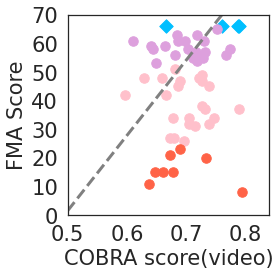

In [17]:
import seaborn as sns
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
sns.set(style='white')


HC_confidence_by_sub = HC_df.groupby('sub').mean()
HC_confidence_by_sub.reset_index(inplace=True, drop=False)

fig, axes = plt.subplots(1,1,figsize=(4,4))

HAR_confidence_only = HAR_df.groupby('sub').mean()
HAR_confidence_only.reset_index(drop=False, inplace=True)
HAR_confidence_only['sub'] = HAR_confidence_only['sub'].astype('int')

FM = pd.read_csv('FM_scores_2.csv')
merged = FM.merge(HAR_confidence_only,left_on='Stroke Pt Number',right_on='sub')
print('motion corr',spearmanr(merged['FM Score'],merged.motion_prob))
print('non-motion corr',spearmanr(merged['FM Score'],merged.non_motion_prob))
print('all corr',spearmanr(merged['FM Score'],merged.all_prob))

color_dict = {'healthy': 'lightskyblue', 'moderate':'pink',  'mild': 'plum','severe':'tomato'}

color = merged.Severity.map(color_dict)
sns.set(style='white')


if True:
    plt.scatter(HC_confidence_by_sub.non_motion_prob, [66]*4, marker='D',color='deepskyblue',s=90, label='healthy(held-out)')
    plt.scatter(merged[merged['Severity']=='mild']['non_motion_prob'], merged[merged['Severity']=='mild']['FM Score'], color='plum',s=90,label='mild')
    plt.scatter(merged[merged['Severity']=='moderate']['non_motion_prob'], merged[merged['Severity']=='moderate']['FM Score'], color='pink',s=90,label='moderate')
    plt.scatter(merged[merged['Severity']=='severe']['non_motion_prob'], merged[merged['Severity']=='severe']['FM Score'], color='tomato',s=90,label='severe')
    plt.xlim(0.5,0.84)
    plt.ylim(0,70)
    
    y = np.concatenate((merged.motion_prob.values, HC_confidence_by_sub.motion_prob.values)) 
    x = np.concatenate((merged['FM Score'].values, np.array([66]*4)))
    r, p, lo, hi = pearsonr_ci(y,x)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(y,x)
    
    x = np.linspace(0.5,1, num=5)
    line = [slope*ii for ii in x] + intercept
    plt.plot(x, line, '--', color='grey',linewidth=3,)
                                             #label = "Correlation coefficient = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
#plt.title("Correlation coefficient = {:.3f} \n (95% C.I. [{:.3f},{:.3f}])".format(r, lo,hi),fontsize=15)
print("Correlation coefficient = {:.3f} \n (95% C.I. [{:.3f},{:.3f}])".format(r, lo,hi),)
plt.xlabel('COBRA score(video)',fontsize=21)
plt.ylabel('FMA Score',fontsize=21)
  
#plt.legend(fontsize=10)#,bbox_to_anchor=(1.5,0.5))
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.tight_layout()
# plt.savefig('plot/video_motion.pdf')



# object color

In [34]:
HAR_confidence_only = HAR_df[HAR_df['act']=='RTT'].groupby('sub').mean()
HAR_confidence_only.reset_index(drop=False, inplace=True)
HAR_confidence_only['sub'] = HAR_confidence_only['sub'].astype('int')

FM = pd.read_csv('FM_scores_2.csv')
merged = FM.merge(HAR_confidence_only,left_on='Stroke Pt Number',right_on='sub')

merged.groupby(['object color','object brightness']).mean()[['FM Score','motion_prob','non_motion_prob','all_prob']]

FM Score  motion_prob  non_motion_prob  \
object color object brightness                                           
blue         dark                 43.250     0.585994         0.632004   
             light                43.625     0.699933         0.658365   
pink         light                42.750     0.671275         0.664646   

                                all_prob  
object color object brightness            
blue         dark               0.648002  
             light              0.699916  
pink         light              0.681465

Correlation coefficient = 0.615 
 (95% C.I. [0.411,0.760])


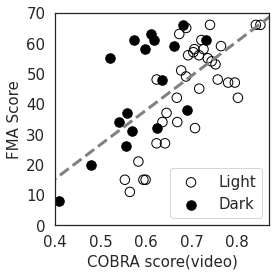

In [36]:
HC_confidence_by_sub = HC_df[HC_df['act']=='RTT'].groupby('sub').mean()
HC_confidence_by_sub.reset_index(inplace=True, drop=False)

fig, axes = plt.subplots(1,1,figsize=(4,4))

HAR_confidence_only = HAR_df[HAR_df['act']=='RTT'].groupby('sub').mean()
HAR_confidence_only.reset_index(drop=False, inplace=True)
HAR_confidence_only['sub'] = HAR_confidence_only['sub'].astype('int')

FM = pd.read_csv('FM_scores_2.csv')
merged = FM.merge(HAR_confidence_only,left_on='Stroke Pt Number',right_on='sub')

color_dict = {'healthy': 'lightskyblue', 'moderate':'pink',  'mild': 'plum','severe':'tomato'}

color = merged.Severity.map(color_dict)
sns.set(style='white')


if True:
    plot = plt.scatter([0.850550, 0.740053, 0.840580], [66]*3, # light colored healthy subjects
                       facecolors='none',edgecolors='black',linewidths=1,s=90, label='Light')
    plot = plt.scatter(HC_confidence_by_sub.motion_prob[2], [66], # dark colored healthy subjects
                       color='black',s=90, label='Dark')
    
    
    cohort = merged[(merged['object color']=='pink')]
    plot = plt.scatter(cohort['motion_prob'],cohort['FM Score'],facecolors='none',edgecolors='black',linewidths=1,s=90)
    
    cohort = merged[(merged['object color']=='blue') &(merged['object brightness']=='light')]
    plt.scatter(cohort['motion_prob'],cohort['FM Score'],facecolors='none',edgecolors='black',linewidths=1,s=90)
    
    cohort = merged[(merged['object color']=='blue') &(merged['object brightness']=='dark')]
    plot = plt.scatter(cohort['motion_prob'],cohort['FM Score'],color='black',s=90)
    
    plt.xlim(0.4,0.87)
    plt.ylim(0,70)
    
    y = np.concatenate((merged.motion_prob.values, HC_confidence_by_sub.motion_prob.values)) 
    x = np.concatenate((merged['FM Score'].values, np.array([66]*4)))
    r, p, lo, hi = pearsonr_ci(y,x)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(y,x)
    
    x = np.linspace(0.3,1, num=5)
    line = [slope*ii for ii in x] + intercept
    plt.plot(x, line, '--', color='grey',linewidth=3,)
                                             #label = "Correlation coefficient = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
# plt.title("Correlation coefficient = {:.3f} \n (95% C.I. [{:.3f},{:.3f}])".format(r, lo,hi),fontsize=18)
print("Correlation coefficient = {:.3f} \n (95% C.I. [{:.3f},{:.3f}])".format(r, lo,hi))
plt.xlabel('COBRA score(video)',fontsize=15)
plt.ylabel('FMA Score',fontsize=15)


plt.legend(fontsize=15)#,bbox_to_anchor=(0,0))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
# plt.savefig('plot/dark_light.pdf')


# blurry video results

S00017_feeding3_1
S00028_RTT_left_side5_2
err: 52.271785
balanced_acc: 0.451718
f1_score: 0.449528
recall_score: 0.451718


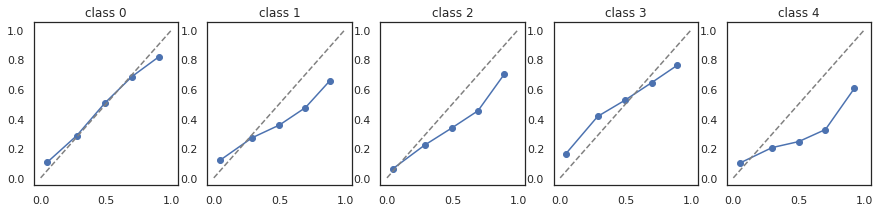

S00017_feeding3_1
S00028_RTT_left_side5_2
err: 53.004618
balanced_acc: 0.432180
f1_score: 0.432987
recall_score: 0.432180


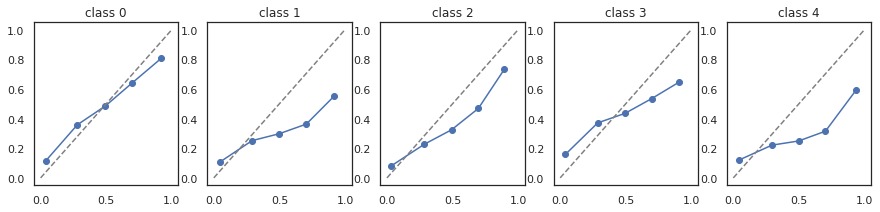

S00017_feeding3_1
S00028_RTT_left_side5_2
err: 51.707641
balanced_acc: 0.467653
f1_score: 0.457987
recall_score: 0.467653


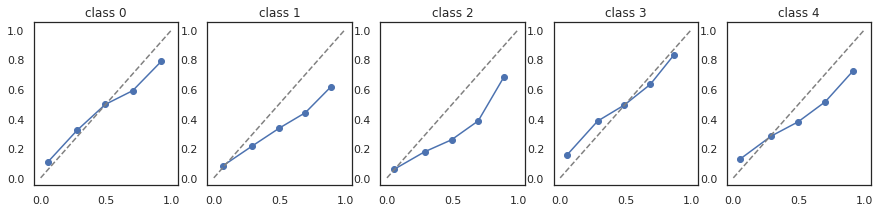

S00017_feeding3_1
S00028_RTT_left_side5_2
err: 52.444623
balanced_acc: 0.448761
f1_score: 0.444846
recall_score: 0.448761


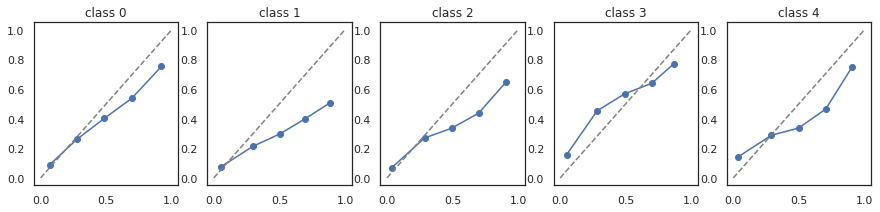

/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


motion corr SpearmanrResult(correlation=0.6237803063248001, pvalue=1.0076911372370575e-06)
motion corr SpearmanrResult(correlation=-0.07259473145336538, pvalue=0.6126836944618488)
motion corr SpearmanrResult(correlation=0.1273011791112976, pvalue=0.37335653907143207)
motion corr SpearmanrResult(correlation=0.4769152320245731, pvalue=0.0004028000661450341)
motion corr SpearmanrResult(correlation=-0.040893975360192715, pvalue=0.7757050262559774)
motion corr SpearmanrResult(correlation=0.2002129181255947, pvalue=0.158933199996855)
motion corr SpearmanrResult(correlation=0.626542800784348, pvalue=8.734682765955697e-07)
motion corr SpearmanrResult(correlation=-0.010189528744234067, pvalue=0.9434251443213955)
motion corr SpearmanrResult(correlation=0.3799562051738836, pvalue=0.0059571656091696465)
motion corr SpearmanrResult(correlation=0.5908115199879005, pvalue=5.015070171364624e-06)
motion corr SpearmanrResult(correlation=-0.018295864945202498, pvalue=0.8986000547455884)
motion corr Spear

In [20]:
for i in range(1,5):
    feature_dir = f'extracted_logits/all_HC_split{i}_best_err/test_blurry'
    test_list = f'preprocessing/splits/split{i}/test_blurry/test.csv'
    process_pred(feature_dir,test_list)
    d = f'extracted_logits/all_HC_split{i}_best_err/processed_videos/test_blurry'
    df = evaluate_model(d) 
    
HAR_blurry_df = None    
for i in range(1,5):
    HC_dir=f'extracted_logits/all_HC_split{i}_best_err/processed_videos/test'
    HAR_dir=f'extracted_logits/all_HC_split{i}_best_err/processed_videos/test_blurry'
    
    _,HAR_blurry_df_split,_=generate_COBRA_from_prob(HC_dir,HAR_dir)
    
    if HAR_blurry_df is None:
        HAR_blurry_df = HAR_blurry_df_split
    else:
        HAR_blurry_df = pd.concat([HAR_blurry_df,HAR_blurry_df_split],ignore_index=True)


# HAR_blurry_df.to_csv('final_result/HAR_blurry_df.csv')


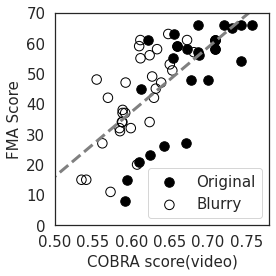

In [20]:
HC_confidence_by_sub = HC_df.groupby('sub').mean()
HC_confidence_by_sub.reset_index(inplace=True, drop=False)

fig, axes = plt.subplots(1,1,figsize=(4,4))

HAR_confidence_only = HAR_df.groupby('sub').mean()
HAR_confidence_only.reset_index(drop=False, inplace=True)
HAR_confidence_only['sub'] = HAR_confidence_only['sub'].astype('int')

FM = pd.read_csv('FM_scores_2.csv')
merged = FM.merge(HAR_confidence_only,left_on='Stroke Pt Number',right_on='sub')


HAR_confidence_only_blurry = HAR_blurry_df.groupby('sub').mean()
HAR_confidence_only_blurry.reset_index(drop=False, inplace=True)
HAR_confidence_only_blurry['sub'] = HAR_confidence_only_blurry['sub'].astype('int')

merged_blurry = FM.merge(HAR_confidence_only_blurry,left_on='Stroke Pt Number',right_on='sub')

color_dict = {'healthy': 'lightskyblue', 'moderate':'pink',  'mild': 'plum','severe':'tomato'}

color = merged.Severity.map(color_dict)
sns.set(style='white')

orig_id = np.random.choice(merged.index, 24)
blur_id = list(set(merged.index) - set(orig_id))

mix = pd.concat((merged.iloc[orig_id,:], merged_blurry_32.iloc[blur_id,:]))

if True:
    plot = plt.scatter(HC_confidence_by_sub.motion_prob, [66]*4,color='black',s=90, label='Original')
    
    
    plot = plt.scatter(mix['motion_prob'][:24],mix['FM Score'][:24],color='black',s=90)
    plot = plt.scatter(mix['motion_prob'][24:],mix['FM Score'][24:],facecolors='none',edgecolors='black',linewidths=1,s=90, label='Blurry')
    
    
    plt.xlim(0.5,0.78)
    plt.ylim(0,70)
    
    y = np.concatenate((mix.motion_prob.values, HC_confidence_by_sub.motion_prob.values)) 
    x = np.concatenate((mix['FM Score'].values, np.array([66]*4)))
    r, p, lo, hi = pearsonr_ci(y,x)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(y,x)
    
    x = np.linspace(0.3,1, num=5)
    line = [slope*ii for ii in x] + intercept
    plt.plot(x, line, '--', color='grey',linewidth=3,)
                                             #label = "Correlation coefficient = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
#plt.title("Correlation coefficient = {:.3f} \n (95% C.I. [{:.3f},{:.3f}])".format(r, lo,hi),fontsize=18)
plt.xlabel('COBRA score(video)',fontsize=15)
plt.ylabel('FMA Score',fontsize=15)


plt.legend(fontsize=15)#,bbox_to_anchor=(0,0))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
# plt.savefig('plot/original_blurry.pdf')
